### Download data from GCS

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
GROUND_TRUTH_FILE = "validation-100.csv"  #@param {type: "string"}
PREDICTION_FILE = "langchain-prompt-bullet-temperature0-100.csv"  #@param {type: "string"}

In [3]:
!gsutil cp gs://cnn-dailymail-data/$GROUND_TRUTH_FILE .
!gsutil cp gs://cnn-dailymail-predictions/$PREDICTION_FILE .

Copying gs://cnn-dailymail-data/validation-100.csv...
/ [1 files][412.0 KiB/412.0 KiB]                                                
Operation completed over 1 objects/412.0 KiB.                                    
Copying gs://cnn-dailymail-predictions/langchain-prompt-bullet-temperature0-100.csv...
/ [1 files][ 43.8 KiB/ 43.8 KiB]                                                
Operation completed over 1 objects/43.8 KiB.                                     


In [4]:
!ls

first-300-chars-100.csv			      langchain-summarize-100.csv
first-300-chars.csv			      sample_data
langchain-prompt-75words-100.csv	      validation-100.csv
langchain-prompt-bullet-100.csv		      validation.csv
langchain-prompt-bullet-temperature0-100.csv


### Compute ROUGE scores

In [5]:
!pip install rouge-score
from rouge_score import rouge_scorer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
val_df = pd.read_csv(GROUND_TRUTH_FILE)
prediction_df = pd.read_csv(PREDICTION_FILE)
assert len(val_df) == len(prediction_df)

In [7]:
df = val_df.merge(prediction_df, on="id")
assert len(df) == len(val_df)

In [8]:
from tqdm import tqdm
tqdm.pandas()

scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"])

def compute_rouge(row):
  score = scorer.score(target=row["highlights"], prediction=row["prediction"])
  return score["rouge1"].fmeasure, score["rouge2"].fmeasure, score["rougeL"].fmeasure

df[["rouge1", "rouge2", "rougeL"]] = df.progress_apply(lambda row: compute_rouge(row), axis=1, result_type="expand")

100%|██████████| 100/100 [00:00<00:00, 360.09it/s]


In [9]:
import numpy as np

np.average(df["rouge1"]), np.average(df["rouge2"]), np.average(df["rougeL"])

(0.3766026428210364, 0.15654129301934241, 0.2573399138136822)

In [10]:
df

,article,highlights,id,prediction,rouge1,rouge2,rougeL
0,A woman has sparked uproar on social media aft...,A woman has caused a social media storm after ...,cf78862daf9e469adda6d53d546069f1c3c00c26,"\n- Karen Davis from Port Pirie, South Austral...",0.521127,0.285714,0.380282
1,Goal hero Christophe Berra said Scotland were ...,Christophe Berra scored late winner for Scotla...,fd8e7f8b2822bedfe93d388f6826c9d7fa81273d,\n- Scotland won 1-0 against Northern Ireland ...,0.285714,0.073171,0.166667
2,"The White House, the State Department and Demo...",White House now claims it didn't know Clinton ...,cb38c8917af2e790f064ca9738842e7629a7d198,"\n- White House, State Department, and Democra...",0.291667,0.084211,0.208333
3,Chelsea took to Instagram on Saturday to back ...,Jose Mourinho had accused pundits of forgettin...,9b3b6f84f08543266d2b3cd590578144057753bb,\n- Chelsea posted pictures of Jamie Carragher...,0.356436,0.141414,0.158416
4,A detailed search for Indian Ocean rubbish on ...,Volunteers have been cleaning a 60-mile stretc...,89be6afd4b20a447af4731c1f461ecf4547b5dd2,\n- Volunteers scoured a 60-mile stretch of co...,0.460317,0.193548,0.333333
...,...,...,...,...,...,...,...
95,An aspiring transgender hip-hop artist who bra...,Padge-Victoria Windslowe convicted of third-de...,a2f75ebd79fe84afc0b50839c657e7e7c16e5da3,"\n- Padge-Victoria Windslowe, an aspiring tran...",0.445946,0.260274,0.405405
96,"Beth Cowan pushed herself to the brink, living...","Beth Cowan, 19, developed bulimia and anorexia...",f0b87cdc64fd2fbd7143724e7ab4cd5c3663533c,"\n- Beth Cowan, 19, of Chester le Street, Coun...",0.404040,0.144330,0.303030
97,If Uxizandre’s Ryanair Chase success on Thursd...,AP McCoy rode his 31st Festival winner on Uxiz...,a58d876fcbbc2c657755fb2ea20bcf6d8dba358c,\n- AP McCoy won his 31st Cheltenham Festival ...,0.486842,0.186667,0.394737
98,"Jasmine Coleman, 12, has been found safe and w...",Jasmine Coleman disappeared from her home at a...,2f9fe03d1f0069ec8aa20389344c0e6b35fe9778,\n- 12-year-old Jasmine Coleman was reported m...,0.534884,0.380952,0.465116


### Write the examples to Google Drive

In [11]:
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [12]:
spreadsheet = gc.create(f"CNN Eval - {PREDICTION_FILE}")

In [13]:
from gspread_dataframe import set_with_dataframe

worst_df = df.sort_values("rougeL").head(10)
worksheet1 = spreadsheet.add_worksheet(title="Worst 10", rows=100, cols=20)
set_with_dataframe(worksheet1, worst_df)

In [14]:
best_df = df.sort_values("rougeL", ascending=False).head(10)
worksheet1 = spreadsheet.add_worksheet(title="Best 10", rows=100, cols=20)
set_with_dataframe(worksheet1, best_df)

### Plot the distribution of the scores

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='rougeL', ylabel='Count'>

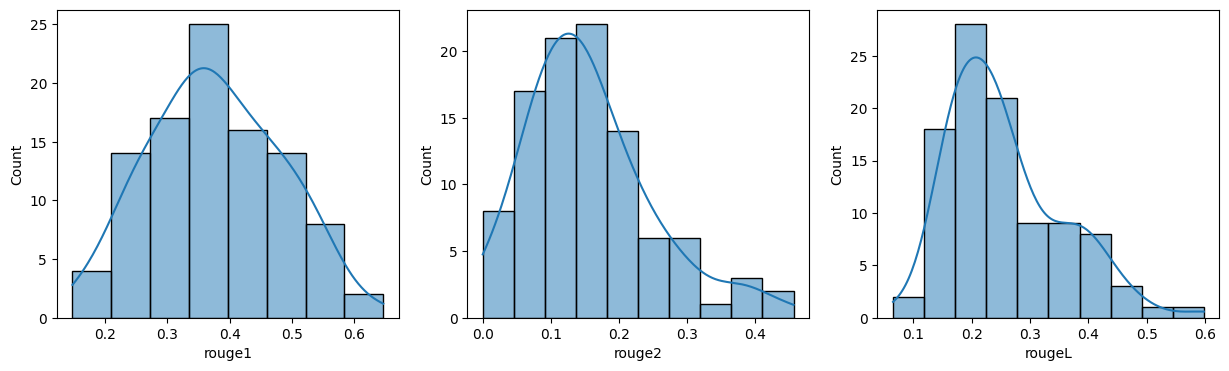

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

sns.histplot(df["rouge1"], kde=True, ax=axs[0])
sns.histplot(df["rouge2"], kde=True, ax=axs[1])
sns.histplot(df["rougeL"], kde=True, ax=axs[2])

### Playground